# Imports
All problem-speciffic files (code) in in the folder `MeshpLaplace2D`, namely the loading of pre-prepared mesh and definition of energy in jax.numpy.

In [20]:
import numpy as np
from mpi4py import MPI
import dolfinx
import ufl
import basix.ufl
from dolfinx import fem, mesh
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType  # type: ignore
from dolfinx.fem.petsc import apply_lifting, assemble_matrix, assemble_vector, set_bc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
import os
from dolfinx.io import XDMFFile

# Specify mesh level
mesh_level = 1  # Change this to the desired level

# Load the mesh from the XDMF file
with XDMFFile(MPI.COMM_WORLD, f"pLaplace_fenics_mesh/mesh_level_{mesh_level}.xdmf", "r") as xdmf_file:
    msh = xdmf_file.read_mesh(name="mesh")

# Define a continuous Galerkin (CG) function space of degree 1
V = fem.functionspace(msh, ("Lagrange", 1))

# --- Define Boundary Conditions ---
msh.topology.create_connectivity(1, 2)  # Ensure facet connectivity for boundary facets
boundary_facets = mesh.exterior_facet_indices(msh.topology)
dofs = fem.locate_dofs_topological(V, 1, boundary_facets)

# Define the Dirichlet boundary condition (u = 0 on boundary nodes)
bc = fem.dirichletbc(ScalarType(0), dofs, V)

In [21]:
# --- Define Variational Problem ---
# Assume mesh and Dirichlet boundary conditions are already set up
# Trial and test functions
u = fem.Function(V)
v = ufl.TestFunction(V)
u_trial = ufl.TrialFunction(V)

# initial guess
u.vector.setArray(1e-3 * np.random.rand(u.vector.array.shape[0]))
set_bc(u.vector, [bc])

# Define parameters
p = 3  # p-Laplacian parameter
f = fem.Constant(msh, ScalarType(-10.0))  # Constant RHS

# Define the energy functional
energy = (1 / p) * ufl.inner(ufl.grad(u), ufl.grad(u))**(p / 2) * ufl.dx - f * u * ufl.dx

# Gradient (variational form)
grad_energy = ufl.derivative(energy, u, v)

# Hessian (second derivative)
hessian = ufl.derivative(grad_energy, u, u_trial)

# Forms
energy_form = fem.form(energy)
grad_form = fem.form(grad_energy)
hessian_form = fem.form(hessian)

In [22]:
# initial energy
fem.assemble_scalar(energy_form)

0.007193851531172988

In [23]:
# initial guess
u.vector.setArray(1e-3 * np.random.rand(u.vector.array.shape[0]))

# Create matrix and vector for linear problem
du = dolfinx.fem.Function(V)
A = dolfinx.fem.petsc.create_matrix(hessian_form)
L = dolfinx.fem.petsc.create_vector(grad_form)
solver = PETSc.KSP().create(msh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.CG)  # Conjugate Gradient
solver.getPC().setType(PETSc.PC.Type.GAMG)  # Algebraic Multigrid Preconditioner
solver.setTolerances(rtol=1e-1)  # Set accuracy for linear solver


i = 0
max_iterations = 100

L2_error = []
du_norm = []
while i < max_iterations:
    # Assemble Jacobian and residual
    start_time = time.time()
    with L.localForm() as loc_L:
        loc_L.set(0)
    A.zeroEntries()
    dolfinx.fem.petsc.assemble_matrix(A, hessian_form, bcs=[bc])
    A.assemble()
    dolfinx.fem.petsc.assemble_vector(L, grad_form)
    L.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    L.scale(-1)
    grad_time = time.time() - start_time

    # Compute b - J(u_D-u_(i-1))
    precond_start_time = time.time()
    dolfinx.fem.petsc.apply_lifting(L, [hessian_form], [[bc]], x0=[u.x.petsc_vec])
    # Set du|_bc = u_{i-1}-u_D
    dolfinx.fem.petsc.set_bc(L, [bc], u.x.petsc_vec)
    L.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)
    precond_time = time.time() - precond_start_time

    # Solve linear problem
    solve_start_time = time.time()
    solver.solve(L, du.x.petsc_vec)
    du.x.scatter_forward()
    solve_time = time.time() - solve_start_time
    grad_inf_norm = L.norm(PETSc.NormType.NORM_INFINITY)

    # Update u_{i+1} = u_i + delta u_i
    u.x.array[:] += du.x.array
    i += 1

    # Compute norm of update
    correction_norm = du.x.petsc_vec.norm(0)
    du_norm.append(grad_inf_norm)

    # Debug info
    print(f"IT {i}: Grad inf-norm = {grad_inf_norm:.3e}, TIMES: Aseembly. = {grad_time:.3f} s, Prec setup = {precond_time:.3f} s, Solve time = {solve_time:.3f} s, Solver its = {solver.getIterationNumber()}")

    if grad_inf_norm < 1e-6:
        print("Converged!")
        break

fem.assemble_scalar(energy_form)

IT 1: Grad inf-norm = 2.500e+00, TIMES: Aseembly. = 0.000 s, Prec setup = 0.000 s, Solve time = 0.000 s, Solver its = 2
IT 2: Grad inf-norm = 1.591e+07, TIMES: Aseembly. = 0.000 s, Prec setup = 0.000 s, Solve time = 0.000 s, Solver its = 2
IT 3: Grad inf-norm = 3.977e+06, TIMES: Aseembly. = 0.000 s, Prec setup = 0.000 s, Solve time = 0.000 s, Solver its = 2
IT 4: Grad inf-norm = 9.846e+05, TIMES: Aseembly. = 0.000 s, Prec setup = 0.000 s, Solve time = 0.000 s, Solver its = 2
IT 5: Grad inf-norm = 2.439e+05, TIMES: Aseembly. = 0.000 s, Prec setup = 0.000 s, Solve time = 0.000 s, Solver its = 2
IT 6: Grad inf-norm = 6.048e+04, TIMES: Aseembly. = 0.000 s, Prec setup = 0.000 s, Solve time = 0.000 s, Solver its = 2
IT 7: Grad inf-norm = 1.502e+04, TIMES: Aseembly. = 0.000 s, Prec setup = 0.000 s, Solve time = 0.000 s, Solver its = 2
IT 8: Grad inf-norm = 3.735e+03, TIMES: Aseembly. = 0.000 s, Prec setup = 0.000 s, Solve time = 0.000 s, Solver its = 2
IT 9: Grad inf-norm = 9.298e+02, TIMES: 

-5.934251214468168

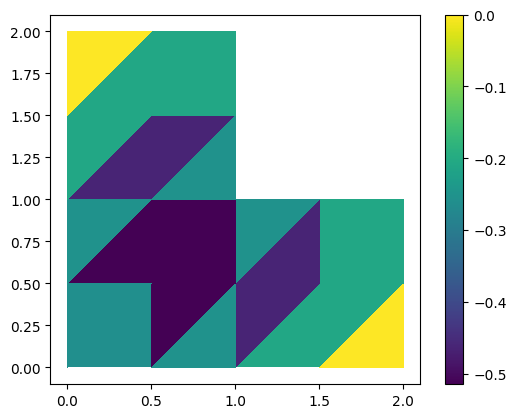

In [24]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.tripcolor(msh.geometry.x[:, 0], msh.geometry.x[:, 1], msh.geometry.dofmap, u.vector.array, shading='flat')
# add colorbar
plt.colorbar(ax.tripcolor(msh.geometry.x[:, 0], msh.geometry.x[:, 1],
             msh.geometry.dofmap, u.vector.array, shading='flat'))
plt.show()

In [25]:
indexes_local = range(*u.vector.getOwnershipRange())
u.vector.getLocalVector().array = u.vector.array[indexes_local]

TypeError: getLocalVector() takes at least 1 positional argument (0 given)

In [17]:
A.getValues(range(0,10), range(0,10))

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.3205498 ,  0.        ,
         0.        , -0.33064419, -0.33064424,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.33064419,  0.        ,
         0.        ,  1.59049311,  0.10299128

In [1]:
import dolfinx
import os
import petsc4py

# Get the path to the dolfinx module
dolfinx_path = os.path.dirname(dolfinx.__file__)
print("dolfinx is located at:", dolfinx_path)

petsc4py_path = os.path.dirname(petsc4py.__file__)
print("petsc4py is located at:", petsc4py_path)

dolfinx is located at: /usr/local/dolfinx-real/lib/python3.10/dist-packages/dolfinx
petsc4py is located at: /usr/local/lib/python3.10/dist-packages/petsc4py
